In [36]:
import config
from cnn_builder import *
from dataset_functions import *
import gc
from hypercube_set import HypercubeSet
from hypercube_loader import *
import papers.aspn
import glob
import keras
import os
import paths
import pickle
from rendering import *

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [ ]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=True, n_max_cubes=inf))
hc_set.print_metadata()

#### Dataset creation
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=test_split, patch_size=config.patch_size,
                            patch_overlapping=30)

In [7]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

In [ ]:
# Look for a file with the network name under the history folder
history_file = os.path.join(paths.result_folder + 'history/', network_name + "*.p")
history_files = glob.glob(history_file)

for history_file in history_files:
    # Load history with pickle
    history = pickle.load(open(history_file, "rb"))
    render_model_history(history, model_name=network_name)

In [ ]:
# Read network weights
network_weights_file = os.path.join(paths.result_folder + 'network/', network_name + "*.h5")
network_weights_files = glob.glob(network_weights_file)
if len(network_weights_files) > 0:
    network_weights_file = network_weights_files[-1]
    print("Loading weights file " + network_weights_file)
    model = keras.models.load_model(network_weights_file,
                                    custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                    'SecondOrderPooling': papers.aspn.SecondOrderPooling})

    model.summary()

## Window Size Tests

### OA

In [82]:
# Read network metrices with network_type root name (e.g. allopezr_2d)
network_metrics_file = os.path.join(paths.result_folder + 'metrics/', network_type + "*_window_size_test.p")
network_metrics_files = glob.glob(network_metrics_file)

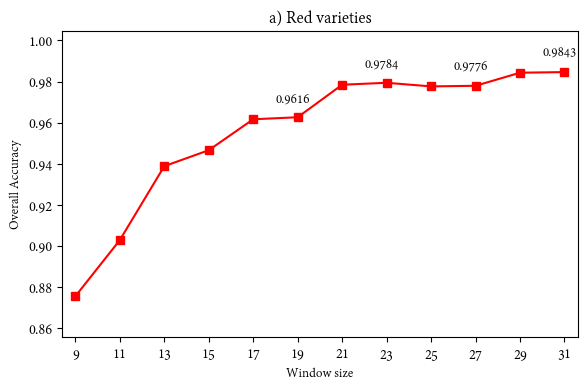

In [119]:
oa_window_size = []

for network_metrics_file in network_metrics_files:
    # Load history with pickle
    network_metrics = pickle.load(open(network_metrics_file, "rb"))
    # Extract patch size from file name
    file_name_strings = network_metrics_file.split("_")
    for string in file_name_strings:
        if 'x' in string:
            patch_size = int(string.split("x")[0])
            break

    oa_window_size.append((patch_size, network_metrics.get_oa()))

# Sort by patch size
oa_window_size.sort(key=lambda tup: tup[0])
render_window_size_metric(oa_window_size, annotate_indices=[4, 6, 8, 10], title="a) Red varieties")

### Training time + capacity

In [105]:
# Read history files
# Read network metrices with network_type root name (e.g. allopezr_2d)
network_history_file = os.path.join(paths.result_folder + 'history/', network_type + "*_window_size_test.p")
network_history_files = glob.glob(network_history_file)

network_file = os.path.join(paths.result_folder + 'network/', network_type + "*_window_size_test_0.h5")
network_files = glob.glob(network_file)

In [120]:
training_time = []
capacity = []

for (history_file, network_file) in zip(network_history_files, network_files):
    # Load history with pickle
    network_history = pickle.load(open(history_file, "rb"))
    # Extract patch size from file name
    file_name_strings = network_file.split("_")
    for string in file_name_strings:
        if 'x' in string:
            patch_size = int(string.split("x")[0])
            break

    model = keras.models.load_model(network_file,
                                custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                'SecondOrderPooling': papers.aspn.SecondOrderPooling})
    model.num_params = model.count_params()

    training_time.append((patch_size, network_history.get_training_time()))
    capacity.append((patch_size, model.num_params))

    del model
    gc.collect()

# Sort by patch size
training_time.sort(key=lambda tup: tup[0])
capacity.sort(key=lambda tup: tup[0])

[(9, 2004.076565504074), (11, 2118.0847680568695), (13, 2242.564688682556), (15, 1929.426745891571), (17, 2182.2053561210632), (19, 2428.403886795044), (21, 2723.6629133224487), (23, 3083.630040884018), (25, 3502.1302626132965), (27, 4033.917908191681), (29, 4622.471698284149), (31, 5505.049726724625)]
[(9, 378635), (11, 378715), (13, 378811), (15, 378923), (17, 396331), (19, 396475), (21, 396635), (23, 396811), (25, 421195), (27, 421403), (29, 421627), (31, 421867)]


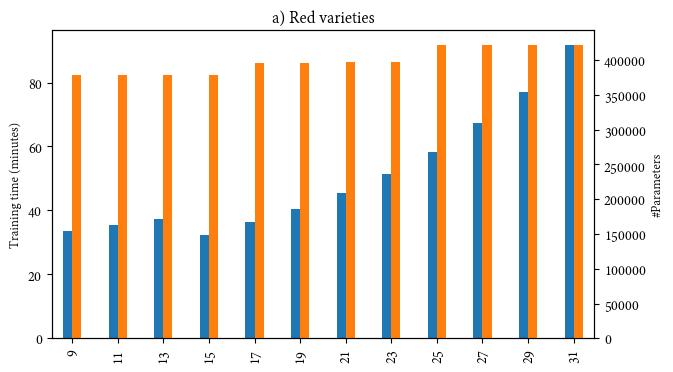

In [156]:
render_time_capacity(training_time, capacity, title="a) Red varieties")

## Ablation study

In [161]:
ablation_suffix = ["no_input_convs", "naive_exception", "advanced_exception", "no_attention"]

# Search files with ablation suffixes in metrics folder
ablation_metrics_files = []
for suffix in ablation_suffix:
    ablation_metrics_file = os.path.join(paths.result_folder + 'metrics/', network_type + "*_" + suffix + ".p")
    ablation_metrics_files.append(glob.glob(ablation_metrics_file))

for (ablation_label, metric_file) in zip(ablation_suffix, ablation_metrics_files):
    # Load history with pickle
    print('------------- ' + ablation_label + ' -------------')
    network_metrics = pickle.load(open(metric_file[0], "rb"))
    print(network_metrics.print_metrics())

------------- no_input_convs -------------
Overall accuracy: 0.9392145659543673 +- 0.008528221622165622
Average accuracy: 0.9392145659543673 +- 0.008528221622165622
Kappa loss: 0.9228060306151755 +- 0.014266322536730857
F1 score: 0.94236550173475 +- 0.007409180639645223
ROC AUC score: 0.9978302843715031 +- 0.00033857100033728225
None
------------- naive_exception -------------
Overall accuracy: 0.9705557460099797 +- 0.0013117872515691594
Average accuracy: 0.9705557460099797 +- 0.0013117872515691987
Kappa loss: 0.9725160058710891 +- 0.0013935260745368773
F1 score: 0.9705631476372242 +- 0.0013129869454663484
ROC AUC score: 0.9984684926094477 +- 0.0001221284057733097
None
------------- advanced_exception -------------
Overall accuracy: 0.9765664876395078 +- 0.001081244505341752
Average accuracy: 0.9765664876395078 +- 0.0010812445053417564
Kappa loss: 0.9746093766197825 +- 0.0022321006420635376
F1 score: 0.9766544918508572 +- 0.0010805677726055736
ROC AUC score: 0.9987877907248919 +- 0.000

# History time and num parameters

In [47]:
from keras.layers import Lambda
import papers.spectral_net

network_types = [ 'allopezr_2d', 'lt_cnn', 'nezami', 'jigsaw_hsi', 'spectral_net', 'hybrid_sn', 'aspn']
network_label = ['Ours', 'Lt-CNN', 'Nezami et al.', 'Jigsaw HSI', 'SpectralNet', 'HybridSN', 'ASPN']
num_params_typeset = [0, 0, 0, 0, 7826889, 0, 8229]
training_time = []
num_params = []

for network_type in network_types:
    print(network_type)
    read_json_config(paths.config_file, network_type=network_type)
    network_name = get_name(network_type)

    # read history pickle file
    history_files = glob.glob(os.path.join(paths.result_folder + 'history/', network_name + ".p"))
    for history_file in history_files:
        history = pickle.load(open(history_file, "rb"))
        training_time.append(history.get_training_time())

    # read network pickle file
    network_files = glob.glob(os.path.join(paths.result_folder + 'network/', network_name + "*.h5"))
    for network_file in network_files:
        try:
            model = keras.models.load_model(network_file,
                                        custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                        'SecondOrderPooling': papers.aspn.SecondOrderPooling})
            model.num_params = model.count_params()
            num_params.append(model.num_params)

            del model
            gc.collect()
            break
        except:
            print("Error loading model")
            num_params.append(num_params_typeset[network_types.index(network_type)])
            break

allopezr_2d
lt_cnn
nezami
jigsaw_hsi
spectral_net
Error loading model
hybrid_sn
aspn
Error loading model


In [48]:
print(training_time)
print(num_params)

[3030.1700570583344, 6636.490574121475, 1617.1864354610443, 12388.88419175148, 2800.2498574256897, 9112.425887346268, 487.5686295032501]
[396811, 3124401, 40539, 28267659, 7826889, 5121273, 8229]


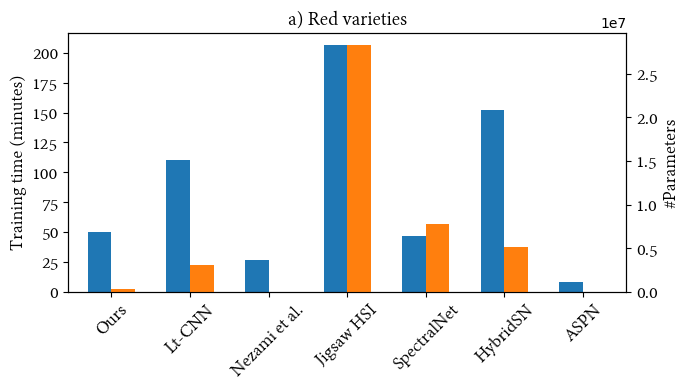

In [64]:
render_network_training(network_label, training_time, num_params, title="a) Red varieties")

# Spatial labelling

In [37]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

Reading media/Mateus_2022/Area01\raw_112_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_1984_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_3904_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_5744_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_7584_rf.hdr ...
Min: 0.006377667188644409, Max: 0.16416394710540771, Size: (1840, 3200, 223)
|████████████████████████████████████████| 313709/313709 [100%] in 1.4s (224893.69/s)                                   
(5888000, 223)
(5888000,)
on 0: (0, 223)                                                                                                          
|⚠︎                                       | (!) 0/2 [0%] in 0.0s (0.00/s)                                                


ValueError: Found array with 0 sample(s) (shape=(0, 223)) while a minimum of 1 is required by FactorAnalysis.

In [40]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=2e32))
hc_set.print_metadata()
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=config.test_split, patch_size=config.patch_size,
                            patch_overlapping=config.patch_overlapping)
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Reading media/Mateus_2022/Area01\raw_112_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_1984_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_3904_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_5744_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_7584_rf.hdr ...
Min: 0.006377667188644409, Max: 0.16416394710540771, Size: (1840, 3200, 223)
(5888000, 223)
(5888000,)
on 0: (274495, 223)                                                                                                     
|████████████████████████████████████████| 2/2 [100%] in 39.7s (0.03/s)                                                 0%] in 19s (~0s, 0.0/s) 


In [41]:
# Load network
network_file = os.path.join(paths.result_folder + 'network/', network_name + "_0.h5")
model = keras.models.load_model(network_file,
                            custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                            'SecondOrderPooling': papers.aspn.SecondOrderPooling})

In [46]:
batch_size = 50000
num_hypercubes = hc_set.get_num_hypercubes()

for i in range(num_hypercubes):
    print("Processing hypercube " + str(i))

    predicted_swath = None
    y_swath = None
    num_processed_pixels = 0

    while True:
        X_train_swath, y_train_swath = hc_set.split_swath(patch_size=config.patch_size, patch_id=i, limit=batch_size, offset=num_processed_pixels)
        if X_train_swath is None:
            break
        if X_train_swath.shape[0] == 0:
            continue

        y_train_swath = reduce_labels_center(y_train_swath)
        predicted_labels = model.predict(X_train_swath)
        predicted_labels = np.argmax(predicted_labels, axis=1)

        if predicted_swath is None:
            predicted_swath = predicted_labels
            y_swath = y_train_swath
        else:
            predicted_swath = np.append(predicted_swath, predicted_labels)
            y_swath = np.append(y_swath, y_train_swath)

        num_processed_pixels += batch_size
        del X_train_swath, y_train_swath, predicted_labels
        gc.collect()

    label_diff = hc_set.compose_swath_evaluation(y_swath, predicted_swath, patch_size=config.patch_size)
    rendering.render_label_diff(label_diff, filename='swaths/' + 'red_' + str(i) + '.png')

    del predicted_swath, y_swath
    gc.collect()

Processing hypercube 0
|████████████████████████████████████████| 50000/50000 [100%] in 0.2s (363213.59/s)                                     
1294/1294 [==============================] - 5s 4ms/step
|████████████████████████████████████████| 50000/50000 [100%] in 0.2s (238373.15/s)                                     
1507/1507 [==============================] - 8s 5ms/step
|████████████████████████████████████████| 50000/50000 [100%] in 0.2s (226122.75/s)                                     
1507/1507 [==============================] - 411s 273ms/step
|████████████████████████████████████████| 50000/50000 [100%] in 0.2s (239664.71/s)                                     
  14/1507 [..............................] - ETA: 3:25:13

KeyboardInterrupt: 